In [1]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
from skimage import transform, color
import cv2 as cv

tuple2int = {
    (1, 1, 1, 1, 1, 1, 0) : 0,
    (0, 1, 1, 0, 0, 0, 0) : 1,
    (1, 1, 0, 1, 1, 0, 1) : 2,
    (1, 1, 1, 1, 0, 0, 1) : 3,
    (0, 1, 1, 0, 0, 1, 1) : 4,
    (1, 0, 1, 1, 0, 1, 1) : 5,
    (0, 0, 1, 1, 1, 1, 1) : 6,
    (1, 1, 1, 0, 0, 0, 0) : 7,
    (1, 1, 1, 1, 1, 1, 1) : 8,
    (1, 1, 1, 0, 0, 1, 1) : 9
}

In [2]:
# импортируем видео и берём первый кадр
cap = cv.VideoCapture('video5v.mp4')
_, frame = cap.read()
cap.release()

# преобразуем в чб и обрезаем
img = color.rgb2gray(frame)[40:160, 60:810]

0
0
1
4
0
0
0
2


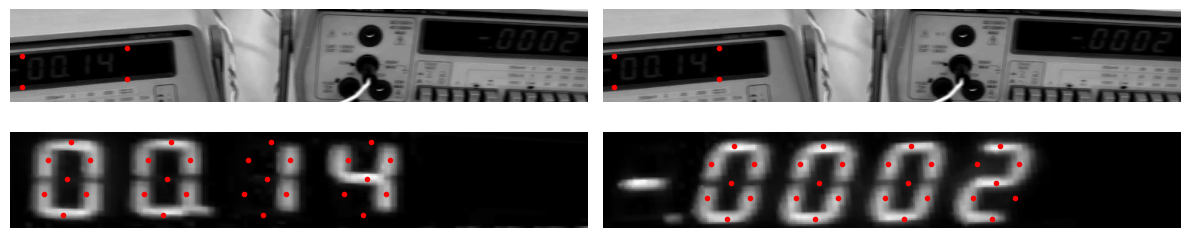

In [4]:
src = np.array([[0, 0], [0, 55], [230, 55], [230, 0]])
dst_1 = np.array([[15, 60], [15, 100], [151, 90], [151, 50]])
dst_2 = np.array([[604, 19], [600, 55], [740, 62], [744, 26]])

warped = [None, None]
# warped = buf
tform3_1 = transform.ProjectiveTransform()
tform3_1.estimate(src, dst_1)
warped[0] = transform.warp(img, tform3_1, output_shape=(50, 300))

tform3_2 = transform.ProjectiveTransform()
tform3_2.estimate(src, dst_2)
warped[1] = transform.warp(img, tform3_2, output_shape=(50, 300))
# warped[0] = buf

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 3))


segments = np.array([[9,34], [18, 44], [36, 42], [47,30], [36, 20], [18, 22], [28, 32]], dtype=int)

shift_x = [0, 0]
shift_y = [52, 46]
start_x = [-4, -2]
start_y = [-3, 34]

min_val = 0.019
delta = 3
for i in range(2):
    ax[0][i].imshow(img, cmap=plt.cm.gray)
    ax[0][i].plot(dst_1[:, 0], dst_1[:, 1], '.r')
    ax[1][i].imshow(warped[i], cmap=plt.cm.gray)

    sh_x = shift_x[i]
    sh_y = shift_y[i]
    numbers = np.array([[0, 0], [sh_x, sh_y], [2*sh_x, 2*sh_y], [3*sh_x, 3*sh_y]])
    for number in numbers:
        bool_arr = []
        for segment in (segments + number + (start_x[i], start_y[i])):
            ax[1][i].plot(segment[1], segment[0], '.r')
            area = warped[i][(segment[0] - delta):(segment[0] + delta), (segment[1] - delta):(segment[1] + delta)]

            bool_arr.append(np.mean(area) > min_val)
            # print(np.mean(area))
        print(tuple2int[tuple(bool_arr)])
        # print(bool_arr)
        
    for a in ax:
        a[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
buf = None

with open("data.csv", "w") as f:
    f.write("U[V], I[uA]\n")

cap = cv.VideoCapture('video5v.mp4')
prev = (0, 0)

while cap.isOpened():
    ret, frame = cap.read()
    
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    img = color.rgb2gray(frame)[40:160, 60:810]
    
    warped[0] = transform.warp(img, tform3_1, output_shape=(50, 300))
    warped[1] = transform.warp(img, tform3_2, output_shape=(50, 300))

    cv.imshow('frame', warped[1])
    
    if cv.waitKey(1) == ord('q'):
        break
    
    v_nums = [[], []]
    
    for i in range(2):
        sh_x = shift_x[i]
        sh_y = shift_y[i]
        numbers = np.array([[0, 0], [sh_x, sh_y], [2*sh_x, 2*sh_y], [3*sh_x, 3*sh_y]])
        for number in numbers:
            bool_arr = []
            for segment in (segments + number + (start_x[i], start_y[i])):
                area = warped[i][(segment[0] - delta):(segment[0] + delta), (segment[1] - delta):(segment[1] + delta)]
                bool_arr.append(np.mean(area) > min_val)

            try:
                v_nums[i].append(tuple2int[tuple(bool_arr)])
            except KeyError:
                buf = warped[i]
                print(f"Error: {i}")
                break
        
    if len(v_nums[0]) + len(v_nums[1]) == 8:
        U = float("".join(list(map(str, v_nums[0]))))/100
        I = float("".join(list(map(str, v_nums[1]))))/10
        if prev != (U, I):
            prev = (U, I)
            with open("data.csv", "a") as f:
                f.write(f"{U}, {I}\n")
        
cap.release()
cv.destroyAllWindows()

libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 0
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 0
Error: 0
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 0
Error: 0
Error: 0
Error: 1
Error: 1
Error: 1
Error: 1
Error: 0
Error: 1
Error: 1
Error: 0
Error: 0
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
E